<a href="https://colab.research.google.com/github/uwsampl/tutorial/blob/master/notebook/03a_TVM_Tutorial_TVMBasics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TVM Basics
=============================================
**Author**:  `Eddie Yan <https://github.com/eqy>`_

This tutorial introduces the basics of declaring and scheduling an operator (2D convolution) in TVM.



Please run the following block to ensure TVM is setup for *this notebook*, each notebook may have its own runtime.



In [1]:
! gsutil cp "gs://tvm-fcrc-binariesd5fce43e-8373-11e9-bfb6-0242ac1c0002/tvm.tar.gz" /tmp/tvm.tar.gz
! mkdir -p /tvm
! tar -xf /tmp/tvm.tar.gz --strip-components=4 --directory /tvm
! ls -la /tvm
# Move this block after we are done with pkg step
! bash /tvm/package.sh
import sys
sys.path.append('/tvm/python')
sys.path.append('/tvm/topi/python')

Copying gs://tvm-fcrc-binariesd5fce43e-8373-11e9-bfb6-0242ac1c0002/tvm.tar.gz...
| [1 files][119.6 MiB/119.6 MiB]                                                
Operation completed over 1 objects/119.6 MiB.                                    
total 164
drwxr-xr-x 21 root root  4096 Jun 17 21:17 .
drwxr-xr-x  1 root root  4096 Jun 17 21:17 ..
drwx------  8 root root  4096 May 31 08:14 3rdparty
drwx------ 12 root root  4096 Jun 17 19:41 apps
drwx------  3 root root  4096 Jun 17 20:16 build
drwx------  4 root root  4096 Jun 17 19:41 cmake
-rw-------  1 root root 11053 Jun 17 19:41 CMakeLists.txt
drwx------  6 root root  4096 Jun 17 19:41 conda
-rw-------  1 root root  5736 Jun 17 19:41 CONTRIBUTORS.md
drwx------  3 root root  4096 Jun 17 19:41 docker
drwx------ 11 root root  4096 Jun 17 19:41 docs
drwx------  4 root root  4096 Jun 17 19:41 golang
drwx------  3 root root  4096 May 31 08:14 include
-rw-------  1 root root 10607 Jun 17 19:41 Jenkinsfile
drwx------  6 root root  4096 Jun 17 

Import packages:

In [0]:
import numpy as np
import tvm
import matplotlib as mpl
from matplotlib import pyplot as plt

Define the convolution shape
---------------------------------------------------------------------------------------------

We will implement a convolution operator similar to those found in networks like ResNet-18.
We begin by defining the shape for the specific convolution we will implement:


In [0]:
input_channels = 64
output_channels = 64
kernel_size = 3
input_height = 56
input_width = 56
padding = (1,1)

output_height = (input_height + 2*padding[0] - kernel_size + 1)
output_width = (input_width + 2*padding[1] - kernel_size + 1)

# We define the input in H, W, C (height, width, channels) layout
input_shape = (input_height+2*padding[0], input_width+2*padding[1], input_channels)
# We define the kernel weights in H, W, I, O (kernel height, kernel width, input
# channel, output channel) layout
weight_shape = (kernel_size, kernel_size, input_channels, output_channels)
# Wed define the output in H, W, C (height, width, channels) layout
output_shape = (output_height, output_width, output_channels)

Define the convolution
---------------------------------------------------------------------------------------------

To define the convolution operator, we first declare placeholders using the shape dimensions we just defined. We then define the reduction axes for the summation that occurs for each output position of the convolution. There are three reduction axes in this case: the vertical spatial axis, the horizontal spatial axis, and the channel axis.



In [0]:
input_placeholder = tvm.placeholder(input_shape, name='data')
weight_placeholder = tvm.placeholder(weight_shape, name='weight')
rc = tvm.reduce_axis((0, input_channels), name='rc')
ry = tvm.reduce_axis((0, kernel_size), name='ry')
rx = tvm.reduce_axis((0, kernel_size), name='rx')
comp = tvm.compute((output_height, output_width, output_channels),
    lambda output_y, output_x, output_channel:
    tvm.sum(input_placeholder[output_y + ry][output_x + rx][rc]
    * weight_placeholder[ry][rx][rc][output_channel],
        axis=[ry, rx, rc])
    )

Generate the Default Schedule
---------------------------------------------------------------------------------------------

After declaring the convolution we can use TVM to generate a default schedule for the convolution. The default schedule is the generic multi-level loop nest implementation without any optimizations applied. Crucially, we will see that the schedule can be manipulated programmatically.



In [5]:
s = tvm.create_schedule(comp.op)
# print the loop nest (default schedule)
print(tvm.lower(s, [input_placeholder, weight_placeholder, comp], simple_mode=True))

produce compute {
  for (output_y, 0, 56) {
    for (output_x, 0, 56) {
      for (output_channel, 0, 64) {
        compute[((((output_y*56) + output_x)*64) + output_channel)] = 0.000000f
        for (ry, 0, 3) {
          for (rx, 0, 3) {
            for (rc, 0, 64) {
              compute[((((output_y*56) + output_x)*64) + output_channel)] = (compute[((((output_y*56) + output_x)*64) + output_channel)] + (data[((((((output_y + ry)*58) + output_x) + rx)*64) + rc)]*weight[((((((ry*3) + rx)*64) + rc)*64) + output_channel)]))
            }
          }
        }
      }
    }
  }
}



We also evaluate the performance of the default schedule.

In [6]:
# compile the function
default_func = tvm.build(s, [input_placeholder, weight_placeholder, comp], target='llvm -mcpu=core-avx2', name='conv')
# create a time evaluator instance for measuring the run time
timer = default_func.time_evaluator(default_func.entry_name, tvm.cpu(0), min_repeat_ms=100)

# data arrays for inputs and outputs to the function
data = np.random.random(input_shape).astype('float32')
weight = np.random.random(weight_shape).astype('float32')
data_tvm = tvm.nd.array(data)
weight_tvm = tvm.nd.array(weight)
output_tvm = tvm.nd.array(np.empty(output_shape).astype('float32'))
# time the execution of the function
res_default = timer(data_tvm, weight_tvm, output_tvm)
print("Conv2D with default schedule finished in:", res_default.mean, "seconds")

Conv2D with default schedule finished in: 0.1485963415 seconds


Scheduling the Convolution
---------------------------------------------------------------------------------------------

Next, we apply some scheduling primitives to the convolution.
A useful transformation for many operators is to reorder the loop axes for better locality.
Here, we can grab references to the spatial and reduction axes of the computation and reorder them.



In [7]:
yo, xo, co = comp.op.axis
ry, rx, rc = s[comp].op.reduce_axis
s[comp].reorder(rx, ry, yo, xo, rc, co)

# print the loop nest (reordered schedule)
print(tvm.lower(s, [input_placeholder, weight_placeholder, comp], simple_mode=True))

reordered_func = tvm.build(s, [input_placeholder, weight_placeholder, comp], target='llvm -mcpu=core-avx2', name='conv')
timer = reordered_func.time_evaluator(reordered_func.entry_name, tvm.cpu(0), min_repeat_ms=100)
res_reorder = timer(data_tvm, weight_tvm, output_tvm)
print("Conv2D with reordered schedule finished in:", res_reorder.mean, "seconds")

produce compute {
  for (output_y.init, 0, 56) {
    for (output_x.init, 0, 56) {
      for (output_channel.init, 0, 64) {
        compute[((((output_y.init*56) + output_x.init)*64) + output_channel.init)] = 0.000000f
      }
    }
  }
  for (rx, 0, 3) {
    for (ry, 0, 3) {
      for (output_y, 0, 56) {
        for (output_x, 0, 56) {
          for (rc, 0, 64) {
            for (output_channel, 0, 64) {
              compute[((((output_y*56) + output_x)*64) + output_channel)] = (compute[((((output_y*56) + output_x)*64) + output_channel)] + (data[((((((output_y + ry)*58) + output_x) + rx)*64) + rc)]*weight[((((((ry*3) + rx)*64) + rc)*64) + output_channel)]))
            }
          }
        }
      }
    }
  }
}

Conv2D with reordered schedule finished in: 0.003521764724137931 seconds


More schedule transformations
---------------------------------------------------
Next, we can vectorize a loop with the `vectorize` schedule primitive.

In [8]:
# print the loop nest (parallelized and reordered schedule)
s[comp].vectorize(co)
print(tvm.lower(s, [input_placeholder, weight_placeholder, comp], simple_mode=True))


reordered_parallel_func = tvm.build(s, [input_placeholder, weight_placeholder, comp], target='llvm -mcpu=core-avx2', name='conv')
timer = reordered_parallel_func.time_evaluator(reordered_parallel_func.entry_name, tvm.cpu(0), min_repeat_ms=100)
res_vectorize = timer(data_tvm, weight_tvm, output_tvm)
print("Conv2D with reordered and vectorized schedule finished in:", res_vectorize.mean, "seconds")

produce compute {
  for (output_y.init, 0, 56) {
    for (output_x.init, 0, 56) {
      compute[ramp((((output_y.init*56) + output_x.init)*64), 1, 64)] = x64(0.000000f)
    }
  }
  for (rx, 0, 3) {
    for (ry, 0, 3) {
      for (output_y, 0, 56) {
        for (output_x, 0, 56) {
          for (rc, 0, 64) {
            compute[ramp((((output_y*56) + output_x)*64), 1, 64)] = (compute[ramp((((output_y*56) + output_x)*64), 1, 64)] + (x64(data[((((((output_y + ry)*58) + output_x) + rx)*64) + rc)])*weight[ramp((((((ry*3) + rx)*64) + rc)*64), 1, 64)]))
          }
        }
      }
    }
  }
}

Conv2D with reordered and vectorized schedule finished in: 0.002902881971428571 seconds


Conclusion
--------------
We showed how to declare and introduced the concept of scheduling in TVM. Scheduling is a very complex process with many co-dependent steps. Effective schedules often require several manipulations which in isolation may not improve performance.

Text(0.5, 0, 'runtime (s)')

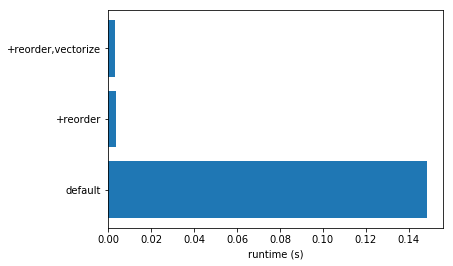

In [13]:
#performance summary
res = [res_default.mean, res_reorder.mean, res_vectorize.mean]
y_pos = np.arange(len(res))
plt.xlabel('runtime (s)')
labels = ['default', '+reorder', '+reorder,vectorize']

plt.barh(y_pos, res)
plt.yticks(y_pos, labels)
